In [73]:
%load_ext autoreload
from ddls.distributions.custom_skew_norm import CustomSkewNorm
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics_from_wandb_run
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics_from_wandb_sweep

from ddls.plotting.plotting import PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import copy

from omegaconf import OmegaConf
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# map to learner agent run path (assume run eval curve ran across multiple seeds)
learner_agent_to_run_path = {
    
    # # beta dist A, num_workers=32
    # 'Ape-X DQN': 'ong/ddls/3cfprsyb', # quantum=10
    # 'Ape-X DQN': 'ong/ddls/1r27t9wj', # quantum=0.01
    # 'Ape-X DQN': 'ong/ddls/x08ia9ap', # quantum=0.01, total_node_bandwidth=1.6e12
    'Ape-X DQN': 'ong/ddls/26by88fa ', # quantum=0.01, total_node_bandwidth=12.5e9
    
    # # beta dist B, num_workers=32
    # 'Ape-X DQN': 'ong/ddls/1qkzsuku', # quantum=10
    # 'Ape-X DQN': 'ong/ddls/3m3dtxvo', # quantum=0.01
    # 'Ape-X DQN': 'ong/ddls/y9q2ot7w', # quantum=0.01, total_node_bandwidth=1.6e12
    
    # # beta dist C, num_workers=32
    # 'Ape-X DQN': 'ong/ddls/1ch4bpuy', # quantum=10
    # 'Ape-X DQN\n(Original)': 'ong/ddls/170nylvp', # quantum=0.01
    # 'Ape-X DQN\n(Tuned LR and $\epsilon$)': 'ong/ddls/1ewu8q67', # quantum=0.01, retuned learning rate and exploration
    # 'Ape-X DQN': 'ong/ddls/1ewu8q67', # quantum=0.01
    # 'Ape-X DQN': 'ong/ddls/3g5dwhk8', # quantum=0.01, total_node_bandwidth=1.6e12
    
    # # beta dist D, num_workers=32
    # 'Ape-X DQN': 'ong/ddls/u9iu4k71', # quantum=10
    # 'Ape-X DQN': 'ong/ddls/2gk91zao', # quantum=0.01
    # 'Ape-X DQN': 'ong/ddls/2np29sr3', # quantum=0.01, total_node_bandwidth=1.6e12
    
}

# map baseline agent to sweep path (assume sweep ran across multiple seeds)
baseline_agent_to_sweep_path = {
    
    # # beta dist A, num_workers=32
    # # quantum=10
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/kidkh3vi',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/iinqx94i',
    # 'Random': 'ong/ddls-scripts/lt3cxu9d',
    # # quantum=0.01
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/rrdbg7ez',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/ozapza8f',
    # 'Random': 'ong/ddls-scripts/miba51py',
    # # quantum=0.01, total_node_bandwidth=1.6e12
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/xprqeqoh',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/lv27j5ia',
    # 'Random': 'ong/ddls-scripts/4f1n6nxa',
    # quantum=0.01, total_node_bandwidth=12.5e9
    'SiP-ML$_{max}$': 'ong/ddls-scripts/2lsctisb',
    'SiP-ML$_{min}$': 'ong/ddls-scripts/e53sy7cj',
    'Random': 'ong/ddls-scripts/odpxuaxg',
    
    # beta dist B, num_workers=32
    # # quantum=10
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/6m9qy360',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/vpwtzdk1',
    # 'Random': 'ong/ddls-scripts/7h7pgdvd',
    # # quantum=0.01
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/bkjweiww',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/1kxig0ue',
    # 'Random': 'ong/ddls-scripts/tvf18nvp',
    # # quantum=0.01, total_node_bandwidth=1.6e12
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/39cz3lq6',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/abxkd48j',
    # 'Random': 'ong/ddls-scripts/9xz174fq',
    
    # # beta dist C, num_workers=32
    # # quantum=10
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/w7tlyrdl',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/ysdt2nxb',
    # 'Random': 'ong/ddls-scripts/ebrgvgeq',
    # # quantum=0.01
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/t7qmcrm7',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/9alj0dxf',
    # 'Random': 'ong/ddls-scripts/30j3ol1z',
    # # quantum=0.01, total_node_bandwidth=1.6e12
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/j627d02o',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/olttukv3',
    # 'Random': 'ong/ddls-scripts/x6ber86a',
    
    # # beta dist D, num_workers=32
    # # quantum=10
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/aqjxk8sv',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/3ys9axpl',
    # 'Random': 'ong/ddls-scripts/6210v6id',
    # # quantum=0.01
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/7ugis4xz',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/720l6rof',
    # 'Random': 'ong/ddls-scripts/wxwg097g',
    # # quantum=0.01, total_node_bandwidth=1.6e12
    # 'SiP-ML$_{max}$': 'ong/ddls-scripts/90nahn4v',
    # 'SiP-ML$_{min}$': 'ong/ddls-scripts/4e5i2xy1',
    # 'Random': 'ong/ddls-scripts/3h0qd3ub',
    
}





In [81]:
# load learner agent run
keys_to_ignore = ['training/'] # for ignoring data not needed for plotting
key_substrings_to_remove = ['evaluation/'] # for tidying up keys
verbose = True
learner_agent_to_episode_stats_dict, learner_agent_to_episode_completion_stats_dict, learner_agent_to_episode_blocked_stats_dict = load_ramp_cluster_environment_metrics_from_wandb_run(learner_agent_to_run_path, keys_to_ignore=keys_to_ignore, key_substrings_to_remove=key_substrings_to_remove, verbose=verbose)

# convert dicts to dataframes
learner_agent_episode_stats_df = pd.DataFrame(learner_agent_to_episode_stats_dict)
display(learner_agent_episode_stats_df)

learner_agent_episode_completion_stats_df = pd.DataFrame(learner_agent_to_episode_completion_stats_dict)
display(learner_agent_episode_completion_stats_df)

learner_agent_episode_blocked_stats_df = pd.DataFrame(learner_agent_to_episode_blocked_stats_dict)
display(learner_agent_episode_blocked_stats_df)


Recorded keys: {'evaluation/jobs_completed_num_nodes_mean', 'evaluation/episode_start_time_max', 'evaluation/mean_mounted_worker_utilisation_frac_min', 'evaluation/step_counter_max', 'summary/', 'evaluation/job_queue_length_min', 'evaluation/jobs_completed_mean_mounted_worker_utilisation_frac_mean', 'evaluation/jobs_completed_num_nodes_max', 'evaluation/mean_mounted_worker_utilisation_frac_mean', 'evaluation/mean_demand_total_throughput_min', 'evaluation/cluster_info_processed_min', 'evaluation/mean_inference_ms', 'evaluation/jobs_blocked_original_demand_num_nodes_mean', 'evaluation/jobs_completed_original_demand_total_operation_memory_cost_mean', 'evaluation/jobs_blocked_original_demand_total_dependency_size_max', 'evaluation/jobs_completed_original_demand_total_operation_memory_cost_min', 'evaluation/job_communication_overhead_time_max', 'evaluation/mean_env_render_ms', 'evaluation/episode_start_time_min', 'evaluation/mean_raw_obs_processing_ms', 'evaluation/jobs_completed_job_seque

,episode_reward_max,flow_info_processed_mean,mean_demand_compute_throughput_mean,dep_info_processed_mean,dep_info_processed_min,num_jobs_blocked_max,mean_flow_throughput_min,acceptance_rate_min,num_jobs_completed_max,mean_flow_throughput_max,...,cluster_info_processed_mean,dep_info_processed_max,num_jobs_arrived_max,compute_info_processed_mean,mean_demand_compute_throughput_min,demand_dep_info_processed_max,mean_demand_total_throughput_min,mean_load_rate_max,episode_start_time_min,Agent
0,-1000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,0.000000e+00,0.000000,0,0.000000e+00,...,0.000000e+00,0.000000e+00,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.161404e+07,0,Ape-X DQN
1,-1000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,0.000000e+00,0.000000,0,0.000000e+00,...,0.000000e+00,0.000000e+00,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.161177e+07,0,Ape-X DQN
2,-1000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,0.000000e+00,0.000000,0,0.000000e+00,...,0.000000e+00,0.000000e+00,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.158769e+07,0,Ape-X DQN
3,-1000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,0.000000e+00,0.000000,0,0.000000e+00,...,0.000000e+00,0.000000e+00,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.160970e+07,0,Ape-X DQN
4,-1000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,0.000000e+00,0.000000,0,0.000000e+00,...,0.000000e+00,0.000000e+00,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.164226e+07,0,Ape-X DQN
5,-1000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,0.000000e+00,0.000000,0,0.000000e+00,...,0.000000e+00,0.000000e+00,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.162125e+07,0,Ape-X DQN
6,-1000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,0.000000e+00,0.000000,0,0.000000e+00,...,0.000000e+00,0.000000e+00,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.159076e+07,0,Ape-X DQN
7,-1000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,0.000000e+00,0.000000,0,0.000000e+00,...,0.000000e+00,0.000000e+00,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.156154e+07,0,Ape-X DQN
8,-1000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1000,0.000000e+00,0.000000,0,0.000000e+00,...,0.000000e+00,0.000000e+00,1001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.156876e+07,0,Ape-X DQN
9,-970,1.331401e+12,3.082838e+05,1.369420e+12,9.566214e+11,993,9.306507e+05,0.006993,15,1.864151e+06,...,1.677704e+12,1.917470e+12,1001,3.082838e+11,2.143771e+05,4.149610e+11,4.206465e+05,3.166861e+07,0,Ape-X DQN


,job_completion_time_speedup_mean,jobs_completed_total_dependency_size_max,jobs_completed_max_acceptable_job_completion_time_mean,job_communication_overhead_time_max,jobs_completed_num_mounted_workers_min,job_completion_time_speedup_min,jobs_completed_max_partitions_per_op_mean,jobs_completed_max_acceptable_job_completion_time_frac_mean,jobs_completed_num_edges_max,jobs_completed_max_acceptable_job_completion_time_frac_min,...,jobs_completed_num_mounted_channels_min,jobs_completed_total_dependency_size_min,job_completion_time_min,job_completion_time_max,job_communication_overhead_time_mean,jobs_completed_total_dependency_size_mean,job_communication_overhead_time_min,jobs_completed_max_acceptable_job_completion_time_frac_max,jobs_completed_num_mounted_channels_max,Agent
0,6.438168,1.366602e+11,31455.597894,839.758853,7.400000,6.229078,7.666667,0.908794,6474.000000,0.888000,...,50.600000,1.234169e+11,5153.398120,6445.636979,795.894119,1.293028e+11,760.802331,0.942667,56.000000,Ape-X DQN
1,6.699531,1.366602e+11,30527.406478,839.758853,8.000000,6.699531,8.000000,0.884203,6474.000000,0.865000,...,56.000000,1.366602e+11,5153.398120,5153.398120,839.758853,1.366602e+11,839.758853,0.906970,56.000000,Ape-X DQN
2,6.667527,1.366602e+11,29840.620789,839.758853,7.877551,6.603519,7.959184,0.864011,6474.000000,0.847755,...,54.897959,1.339575e+11,5153.398120,5417.133261,834.391969,1.357593e+11,823.658202,0.886897,56.000000,Ape-X DQN
3,6.583250,1.366602e+11,28996.770346,839.758853,7.731343,6.500033,7.841482,0.838188,6474.000000,0.821429,...,53.582090,1.300964e+11,5153.398120,5735.526981,816.776902,1.327060e+11,801.446389,0.853134,56.000000,Ape-X DQN
4,6.357895,1.302680e+11,28061.961219,828.546514,7.600000,6.239358,7.535642,0.811038,6139.541176,0.787667,...,52.977778,1.255435e+11,5592.834732,6093.825480,810.979738,1.284705e+11,790.696827,0.832388,53.576471,Ape-X DQN
5,5.849381,1.164760e+11,27856.879033,784.734799,7.082474,5.819799,6.817061,0.795200,5286.886598,0.783725,...,47.490196,1.137196e+11,6360.337966,6736.566613,765.485841,1.147439e+11,754.062435,0.803627,50.039216,Ape-X DQN
6,5.816263,1.165011e+11,28255.134252,764.039492,6.921875,5.655093,6.759529,0.802469,5451.555556,0.793906,...,46.328125,1.071924e+11,6407.628304,7031.845891,746.054897,1.124671e+11,724.487059,0.809333,47.777778,Ape-X DQN
7,5.498321,1.057804e+11,26717.434805,733.561716,6.578231,5.447021,6.328079,0.755792,4904.026846,0.751497,...,42.068027,1.052939e+11,7168.743961,7283.224904,728.895318,1.055345e+11,725.997338,0.761987,45.315436,Ape-X DQN
8,5.511833,1.054951e+11,26874.496589,723.269433,6.645963,5.456981,6.337397,0.762656,5082.026596,0.752021,...,43.155280,1.038558e+11,7179.157720,7232.146666,719.217336,1.047294e+11,711.827639,0.773152,47.393617,Ape-X DQN
9,5.309844,1.028087e+11,26265.050703,722.598538,6.410000,5.255402,6.079289,0.738505,4539.136612,0.732459,...,40.415301,9.812385e+10,7447.745911,7952.270233,706.799317,1.009598e+11,684.851500,0.747005,40.880000,Ape-X DQN


,jobs_blocked_num_nodes_max,jobs_blocked_num_edges_max,jobs_blocked_original_demand_num_nodes_max,jobs_blocked_max_acceptable_job_completion_time_mean,jobs_blocked_original_demand_num_edges_mean,jobs_blocked_total_dependency_size_max,jobs_blocked_num_nodes_min,jobs_blocked_original_demand_num_nodes_min,jobs_blocked_original_demand_total_operation_memory_cost_min,jobs_blocked_original_demand_total_dependency_size_min,...,jobs_blocked_original_demand_num_nodes_mean,jobs_blocked_max_acceptable_job_completion_time_min,jobs_blocked_total_operation_memory_cost_mean,jobs_blocked_max_acceptable_job_completion_time_frac_min,jobs_blocked_max_acceptable_job_completion_time_max,jobs_blocked_original_demand_num_edges_max,jobs_blocked_original_demand_total_operation_memory_cost_max,jobs_blocked_job_sequential_completion_time_mean,jobs_blocked_total_operation_memory_cost_max,Agent
0,100.546000,111.982000,100.546000,16606.520644,111.908000,1.593896e+10,100.440000,100.440000,1.566579e+10,1.592700e+10,...,100.492000,16559.391695,1.567160e+10,0.554440,16660.521646,111.982000,1.567485e+10,29946.655067,1.567485e+10,Ape-X DQN
1,100.420000,111.840000,100.420000,16623.409706,111.800000,1.594970e+10,100.380000,100.380000,1.561629e+10,1.587446e+10,...,100.400000,16438.482332,1.565225e+10,0.540610,16797.227232,111.840000,1.568821e+10,29945.160000,1.568821e+10,Ape-X DQN
2,100.404000,111.800000,100.404000,16472.489974,111.784000,1.592126e+10,100.354000,100.354000,1.563736e+10,1.589437e+10,...,100.384000,16111.737862,1.564819e+10,0.540930,16680.425136,111.800000,1.565996e+10,29946.559800,1.565996e+10,Ape-X DQN
3,100.444000,111.864000,100.444000,16377.010009,111.770000,1.592281e+10,100.318000,100.318000,1.560978e+10,1.586733e+10,...,100.367333,16240.694181,1.564489e+10,0.546340,16561.593101,111.864000,1.566562e+10,29924.138900,1.566562e+10,Ape-X DQN
4,100.380000,111.760000,100.380000,16614.410632,111.702667,1.594970e+10,100.296000,100.296000,1.564302e+10,1.589593e+10,...,100.325333,16265.269353,1.566328e+10,0.539410,16930.980948,111.760000,1.568821e+10,29953.103183,1.568821e+10,Ape-X DQN
5,100.546000,111.982000,100.546000,16506.110370,111.816000,1.592700e+10,100.350000,100.350000,1.564523e+10,1.590430e+10,...,100.417333,16253.256855,1.565465e+10,0.545910,16695.130291,111.982000,1.566579e+10,29955.448583,1.566579e+10,Ape-X DQN
6,100.450000,111.870000,100.450000,16580.844129,111.797333,1.591069e+10,100.304000,100.304000,1.562399e+10,1.588364e+10,...,100.389333,16453.486185,1.563787e+10,0.550460,16732.931134,111.870000,1.565157e+10,29924.409300,1.565157e+10,Ape-X DQN
7,100.504000,111.940000,100.504000,16426.445330,111.872000,1.592823e+10,100.360000,100.360000,1.562966e+10,1.588520e+10,...,100.454667,16298.496725,1.564568e+10,0.546240,16500.831521,111.940000,1.566148e+10,29936.502483,1.566148e+10,Ape-X DQN
8,100.460000,111.876000,100.460000,16482.534133,111.752667,1.590290e+10,100.204000,100.204000,1.562881e+10,1.587962e+10,...,100.356667,16320.976677,1.563741e+10,0.548160,16673.284738,111.876000,1.564455e+10,29933.337217,1.564455e+10,Ape-X DQN
9,100.806061,112.347475,100.806061,16487.509895,112.109643,1.584486e+10,100.338369,100.338369,1.546581e+10,1.574401e+10,...,100.600089,16284.468217,1.551718e+10,0.544119,16717.713691,112.347475,1.557040e+10,29870.389661,1.557040e+10,Ape-X DQN


In [82]:
# load baseline agent sweep
keys_to_ignore = ['valid/step_stats/'] # for ignoring data not needed for plotting
key_substrings_to_remove = ['valid/episode_stats/'] # for tidying up keys
verbose = False
baseline_agent_to_episode_stats_dict, baseline_agent_to_episode_completion_stats_dict, baseline_agent_to_episode_blocked_stats_dict = load_ramp_cluster_environment_metrics_from_wandb_sweep(baseline_agent_to_sweep_path, keys_to_ignore=keys_to_ignore, key_substrings_to_remove=key_substrings_to_remove, verbose=verbose)
        
# convert dicts to dataframes
baseline_agent_episode_stats_df = pd.DataFrame(baseline_agent_to_episode_stats_dict)
display(baseline_agent_episode_stats_df)

baseline_agent_episode_completion_stats_df = pd.DataFrame(baseline_agent_to_episode_completion_stats_dict)
display(baseline_agent_episode_completion_stats_df)

baseline_agent_episode_blocked_stats_df = pd.DataFrame(baseline_agent_to_episode_blocked_stats_dict)
display(baseline_agent_episode_blocked_stats_df)


Agent SiP-ML$_{max}$ sweep <Sweep ong/ddls-scripts/2lsctisb (RUNNING)> parameters:
	experiment.seed:
		{'values': [0, 1, 2]}
Loading data from 3 runs...
Loaded data for run 1 of 3 (<Run ong/ddls-scripts/57egh8fo (running)>) in 0.204.
Loaded data for run 2 of 3 (<Run ong/ddls-scripts/e54mdn96 (running)>) in 0.201.
Loaded data for run 3 of 3 (<Run ong/ddls-scripts/9lfx5w4k (running)>) in 0.207.
Loaded data for agent SiP-ML$_{max}$ sweep <Sweep ong/ddls-scripts/2lsctisb (RUNNING)> (num_runs=3) in 1664956404.311 s.

Agent SiP-ML$_{min}$ sweep <Sweep ong/ddls-scripts/e53sy7cj (FINISHED)> parameters:
	experiment.seed:
		{'values': [0, 1, 2]}
Loading data from 3 runs...
Loaded data for run 1 of 3 (<Run ong/ddls-scripts/4n12tcue (finished)>) in 0.428.
Loaded data for run 2 of 3 (<Run ong/ddls-scripts/gwi8zqg2 (finished)>) in 0.434.
Loaded data for run 3 of 3 (<Run ong/ddls-scripts/s6vvkxpl (finished)>) in 0.422.
Loaded data for agent SiP-ML$_{min}$ sweep <Sweep ong/ddls-scripts/e53sy7cj (FINI

,Agent,dep_info_processed,num_jobs_arrived,blocking_rate,episode_end_time,mean_demand_total_throughput,compute_info_processed,num_jobs_blocked,mean_demand_compute_throughput,episode_time,...,episode_start_time,mean_flow_throughput,demand_total_info_processed,mean_dep_throughput,cluster_info_processed,mean_compute_throughput,mean_load_rate,mean_cluster_throughput,config,experiment.seed
0,SiP-ML$_{min}$,1.937818e+13,1001,0.310689,1000000,2.201277e+07,1.090329e+13,311,1.090329e+07,1000000,...,0,1.457729e+07,2.201277e+13,1.937818e+07,3.028146e+13,1.090329e+07,3.157920e+07,3.028146e+07,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2
1,SiP-ML$_{min}$,1.912381e+13,1001,0.298701,1000000,2.183510e+07,1.084715e+13,299,1.084715e+07,1000000,...,0,1.438926e+07,2.183510e+13,1.912381e+07,2.997096e+13,1.084715e+07,3.151933e+07,2.997096e+07,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1
2,SiP-ML$_{min}$,1.911336e+13,1001,0.311688,1000000,2.185590e+07,1.083159e+13,312,1.083159e+07,1000000,...,0,1.434051e+07,2.185590e+13,1.911336e+07,2.994494e+13,1.083159e+07,3.158562e+07,2.994494e+07,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0
3,Random,2.270170e+13,1001,0.541459,1000000,1.477843e+07,7.303247e+12,542,7.303247e+06,1000000,...,0,2.099687e+07,1.477843e+13,2.270170e+07,3.000495e+13,7.303247e+06,3.160970e+07,3.000495e+07,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2
4,Random,2.130498e+13,1001,0.531469,1000000,1.477896e+07,7.328817e+12,532,7.328817e+06,1000000,...,0,1.944521e+07,1.477896e+13,2.130498e+07,2.863380e+13,7.328817e+06,3.161818e+07,2.863380e+07,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1
5,Random,2.299477e+13,1001,0.535465,1000000,1.495062e+07,7.423416e+12,536,7.423416e+06,1000000,...,0,2.118959e+07,1.495062e+13,2.299477e+07,3.041819e+13,7.423416e+06,3.157804e+07,3.041819e+07,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0


,Agent,jobs_completed_max_partitions_per_op,job_communication_overhead_time,jobs_completed_original_demand_num_nodes,jobs_completed_num_edges,job_computation_overhead_time,jobs_completed_max_acceptable_job_completion_time_frac,jobs_completed_original_demand_total_operation_memory_cost,jobs_completed_max_acceptable_job_completion_time,jobs_completed_job_sequential_completion_time,...,jobs_completed_original_demand_total_dependency_size,job_completion_time,jobs_completed_total_dependency_size,job_completion_time_speedup,jobs_completed_total_operation_memory_cost,jobs_completed_num_mounted_channels,jobs_completed_mean_mounted_worker_utilisation_frac,jobs_completed_num_mounted_workers,config,experiment.seed
0,SiP-ML$_{min}$,2.550073,289.648226,101.283019,794.477504,13192.502785,0.654949,1.572863e+10,19576.609129,30043.652758,...,1.602066e+10,13411.164858,2.796794e+10,2.491593,1.572863e+10,7.068215,2.538229e+06,2.879536,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2
1,SiP-ML$_{min}$,2.549215,293.343786,98.910128,755.430813,12904.607082,0.655849,1.533590e+10,19275.817352,29522.462197,...,1.552744e+10,13109.213371,2.705776e+10,2.493295,1.533590e+10,7.309558,2.857278e+06,2.931526,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1
2,SiP-ML$_{min}$,2.588663,300.901491,100.372093,818.069767,13153.908431,0.655436,1.555913e+10,19700.270364,30244.588590,...,1.582531e+10,13363.324976,2.748635e+10,2.529124,1.555913e+10,8.055233,2.977186e+06,2.995640,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0
3,Random,5.419214,350.868532,101.122271,3960.500000,7627.858923,0.632707,1.587149e+10,19307.202117,30607.495306,...,1.624067e+10,7911.909117,4.934580e+10,5.063788,1.587149e+10,41.493450,1.557887e+06,6.078603,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2
4,Random,5.064103,343.105409,100.055556,3244.102564,7649.101119,0.645085,1.558825e+10,19329.517416,30117.818269,...,1.584681e+10,7927.896407,4.529715e+10,4.773598,1.558825e+10,35.333333,1.618713e+06,5.713675,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1
5,Random,5.433190,352.647969,98.853448,3847.961207,7682.963449,0.632091,1.591899e+10,19102.323829,30435.260022,...,1.614586e+10,7980.265614,4.939993e+10,5.067003,1.591899e+10,41.073276,1.438963e+06,6.081897,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0


,Agent,jobs_blocked_original_demand_num_nodes,jobs_blocked_max_acceptable_job_completion_time,jobs_blocked_original_demand_total_dependency_size,jobs_blocked_max_acceptable_job_completion_time_frac,jobs_blocked_num_nodes,jobs_blocked_original_demand_num_edges,jobs_blocked_total_dependency_size,jobs_blocked_job_sequential_completion_time,jobs_blocked_total_operation_memory_cost,jobs_blocked_num_edges,jobs_blocked_original_demand_total_operation_memory_cost,config,experiment.seed
0,SiP-ML$_{min}$,97.942122,9403.509672,1.565360e+10,0.307138,97.942122,108.922830,1.565360e+10,29718.112701,1.548031e+10,108.922830,1.548031e+10,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2
1,SiP-ML$_{min}$,103.759197,10837.876776,1.672396e+10,0.345485,103.759197,115.461538,1.672396e+10,30824.028930,1.631837e+10,115.461538,1.631837e+10,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1
2,SiP-ML$_{min}$,100.750000,9275.880569,1.618511e+10,0.314263,100.750000,112.429487,1.618511e+10,29291.096314,1.592785e+10,112.429487,1.592785e+10,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0
3,Random,99.678967,14021.795245,1.565422e+10,0.475314,99.678967,111.047970,1.565422e+10,29381.520572,1.549166e+10,111.047970,1.549166e+10,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",2
4,Random,100.958647,14595.247781,1.605069e+10,0.490808,100.958647,112.484962,1.605069e+10,29857.439098,1.577774e+10,112.484962,1.577774e+10,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",1
5,Random,101.544776,14132.856259,1.571521e+10,0.474683,101.544776,113.365672,1.571521e+10,29573.348694,1.543317e+10,113.365672,1.543317e+10,"{""wandb"": {""value"": {""init"": {""entity"": ""ong"",...",0


In [83]:
# add normalised 'score' column

# get best learner agent score
best_learner_performance_val = learner_agent_episode_stats_df['blocking_rate_min'].min()
# grouped_per_epoch_agent_performance_vals = learner_agent_episode_stats_df.groupby(['Agent', 'epoch_counter'])['blocking_rate_mean']
# agent_mean_per_epoch_performance_vals = []
# for key, item in grouped_per_epoch_agent_performance_vals:
#     _agent = key[0]
#     agent_mean_per_epoch_performance_vals.append(item.mean())
# best_learner_performance_val = np.min(agent_mean_per_epoch_performance_vals)

# get best baseline agent score
best_baseline_performance_val = baseline_agent_episode_stats_df['blocking_rate'].min()
    
# get best score across agents
best_performance_val = min(best_learner_performance_val, best_baseline_performance_val)

# add normalised score column to all dataframes
for extension in ['min', 'mean', 'max']:
    learner_agent_episode_stats_df[f'score_{extension}'] = best_performance_val / learner_agent_episode_stats_df[f'blocking_rate_{extension}']
baseline_agent_episode_stats_df['score'] = best_performance_val / baseline_agent_episode_stats_df['blocking_rate']

In [84]:
def lineplot(df, baseline_agent_df, metric):
    aesthetics = PlotAesthetics()
    aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

    estimator = np.mean # np.mean np.median

    # scaling_factor = 1.5
    scaling_factor = 0.6
    width_scaling_factor = 1
    height_scaling_factor = 1

    # xaxis = 'mean_load_rate'
    # xaxis = episode_stats_df['grouped_mean_load_rate']
    # xaxis_label = 'Load\nRate (B/s)'
    # xaxis = None

    xaxis = learner_agent_episode_stats_df['epoch_counter']
    xaxis_label = 'Learner Steps'
    # xaxis = learner_agent_episode_stats_df['actor_step_counter']
    # xaxis_label = 'Actor Steps'
    # xaxis = learner_agent_episode_stats_df['episode_counter']
    # xaxis_label = 'Episodes'
    # xaxis = learner_agent_episode_stats_df['run_time']
    # xaxis_label = 'Training Time (Hours)' # will convert time units automatically ['Seconds', 'Minutes', 'Hours', 'Days']

    metric_to_yaxis_label = {
        'episode_reward': 'Episode Return',
        'mean_cluster_throughput': 'Cluster Throughput (B/s)',
        'mean_demand_total_throughput': 'Demand Throughput (B/s)',
        'blocking_rate': 'Blocking Rate',
        'job_completion_time': 'JCT (s)',
        'score': 'Score',
    }

    hue = 'Agent'

    # style = None
    style = 'Agent'

    # errorbar = ('ci', 95)
    errorbar = 100 # plot all samples
    # errorbar = 95
    # errorbar = 'sd'

    markers = False
    # markers = True

    linewidth = aesthetics.linewidth

    legend = 'auto'
    # legend = None

    xlim = None
    # xlim = [0, 2]

    ylim = None
    # ylim = [20, 100]

    xaxis_label_style = 'plain' # sci plain
    yaxis_label_style = 'plain' # sci plain
    # yaxis_label_style = 'sci' # sci plain

    # ylog = True
    ylog = False
    # xlog = True
    xlog = False

    use_manual_error_bars = True
    # use_manual_error_bars = False

    learner_display_raw_val = False
    # learner_display_raw_val = True
    
    learner_draw_best_val_line = False
    # learner_draw_best_val_line = True

    metric_to_goal = {
        'episode_reward': 'maximise',
        'mean_cluster_throughput': 'maximise', 
        'mean_demand_total_throughput': 'maximise', 
        'blocking_rate': 'minimise',
        'score': 'maximise',
    }
    
    # title = None
    # title = '$\\beta_{A}$'
    # title = '$\\beta_{B}$'
    title = '$\\beta_{C}$'
    # title = '$\\beta_{D}$'






    # baselines line params
    baseline_linestyle = '--'

    baseline_display_raw_val = False
    # baseline_display_raw_val = True
    # display_raw_val_relative_pos = 0.8
    # display_raw_val_relative_pos = 0.1
    display_raw_val_relative_pos = 1
    display_raw_val_num_sigfigs = 3
    # display_raw_val_num_sigfigs = 2


    # set hue order for colour palette
    hue_order = list(learner_agent_to_run_path.keys())
    hue_order.extend(list(baseline_agent_to_sweep_path.keys()))
    print(f'hue_order: {hue_order}')
    
    # generate colour for each agent given hue order and colour palette
    _palette = iter(sns.color_palette(aesthetics.palette))
    palette = {agent: next(_palette) for agent in hue_order}
    print(palette)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    print(f'Plotting metric {metric} -> min={np.min(df[metric+"_mean"])} | max={np.max(df[metric+"_mean"])} | mean={np.mean(df[metric+"_mean"])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    
    if use_manual_error_bars:
        # HACK: Go through and group mean, min, max into one y label so seaborn can plot min max error bars from RLlib min max summary
        # N.B. Since Seaborn will take its mean from RLlib min, max, mean rather than the original data RLlib got its mean from,
        # the mean value plotted by seaborn will be different from RLlib and biased by the min/max values.
        # You should check how different these are by setting use_manual_error_bars=True/False to see if it's a problem
        _df = defaultdict(list)
        _xaxis = []
        for extension in ['_mean', '_max', '_min']:
            metric_vals = df[metric+extension].tolist()
            hue_vals = df[hue].tolist()
            epoch_counter_vals = df['epoch_counter'].tolist()
            if xaxis is None:
                xaxis_vals = df.index.tolist()
            else:
                xaxis_vals = xaxis.tolist()
            _df[metric].extend(metric_vals)
            _df[hue].extend(hue_vals)
            _df['epoch_counter'].extend(epoch_counter_vals)
            _xaxis.extend(xaxis_vals)
        _df = pd.DataFrame(_df)
        _y = metric
        errorbar = 100 # plot all samples
    else:
        _df = df
        _y = metric + '_mean'
        if xaxis is None:
            _xaxis = df.index
        else:
            _xaxis = xaxis
        errorbar = 100
    
    if 'Training Time' in xaxis_label:
        units = xaxis_label.split('(')[-1].split(')')[0]
        _xaxis = np.array(_xaxis)
        if units == 'Seconds':
            xaxis = _xaxis
        elif units == 'Minutes':
            xaxis = _xaxis / 60
        elif units == 'Hours':
            xaxis = _xaxis / 60
            xaxis /= 60
        elif units == 'Days':
            xaxis = _xaxis / 60
            xaxis /= 60
            xaxis /= 24
        else:
            raise Exception(f'Unrecognised run_time xaxis label units {units}')
    else:
        xaxis = _xaxis
        
    
    g = sns.lineplot(data=_df, 
                     x=xaxis, 
                     y=_y, 
                     hue=hue, 
                     style=style,
                     markers=markers,
                     linewidth=linewidth,
                     legend=legend,
                     ci=errorbar,
                     palette=palette,
                    )
    
    agent_to_best_metric_mean = {}
    agent_to_best_metric_min = {}
    agent_to_best_metric_max = {}
    
    if _y in baseline_agent_df.columns:
        # groupby baseline_agent column and estimate the mean of the _y metric column
        baseline_agent_to_mean_y_val = baseline_agent_df.groupby([hue])[_y].mean()
        baseline_agent_to_min_uncertainty_y_val = baseline_agent_to_mean_y_val - baseline_agent_df.groupby([hue])[_y].min()
        baseline_agent_to_max_uncertainty_y_val = baseline_agent_df.groupby([hue])[_y].max() - baseline_agent_to_mean_y_val
        for baseline_agent in baseline_agent_to_sweep_path.keys():
            agent_to_best_metric_mean[baseline_agent] = baseline_agent_to_mean_y_val[baseline_agent]
            agent_to_best_metric_min[baseline_agent] = baseline_agent_to_min_uncertainty_y_val[baseline_agent]
            agent_to_best_metric_max[baseline_agent] = baseline_agent_to_max_uncertainty_y_val[baseline_agent]
            if yaxis_label_style == 'plain':
                # rounded_text = f'{sigfig.round(baseline_agent_to_mean_y_val[baseline_agent], sigfigs=display_raw_val_num_sigfigs)}'
                rounded_text = f'{sigfig.round(agent_to_best_metric_mean[baseline_agent], sigfigs=display_raw_val_num_sigfigs)}'
            else:
                rounded_text = f'{sigfig.round(agent_to_best_metric_mean[baseline_agent], sigfigs=display_raw_val_num_sigfigs):.3e}'
            if '.' not in rounded_text[:display_raw_val_num_sigfigs]:
                # no need for decimal
                rounded_text = rounded_text.split('.')[0]
            g.axhline(baseline_agent_to_mean_y_val[baseline_agent], 
                      label=baseline_agent, 
                      linewidth=linewidth,
                      linestyle=baseline_linestyle,
                      color=palette[baseline_agent],
                     )
            rounded_text = f'$\\approx${rounded_text}'
            # print(f'\nAgent {baseline_agent} best {metric}: {agent_to_best_metric_mean[baseline_agent]} (uncertainty_min={agent_to_best_metric_min[baseline_agent]} | uncertainty_max={agent_to_best_metric_max[baseline_agent]})')
            if baseline_display_raw_val:
                # the x coords of this transformation are data, and the y coord are axeshttps://stackoverflow.com/questions/13413112/creating-labels-where-line-appears-in-matplotlib-figure
                rounded_text = f'$\\approx${rounded_text}'
                trans = ax.get_yaxis_transform()
                plt.text(x=display_raw_val_relative_pos, 
                         y=baseline_agent_to_mean_y_val[baseline_agent], 
                         s=rounded_text, 
                         transform=trans)
    else:
        print(f'Metric {_y} not in baseline agent df columns ({baseline_agent_df.columns}), skipping...')
        
    grouped_per_epoch_agent_y_vals = _df.groupby([hue, 'epoch_counter'])[_y]
    agent_to_mean_per_epoch_y_vals = defaultdict(list)
    agent_to_min_per_epoch_y_vals = defaultdict(list)
    agent_to_max_per_epoch_y_vals = defaultdict(list)
    for key, item in grouped_per_epoch_agent_y_vals:
        _agent = key[0]
        agent_to_mean_per_epoch_y_vals[_agent].append(item.mean())
        agent_to_min_per_epoch_y_vals[_agent].append(item.min())
        agent_to_max_per_epoch_y_vals[_agent].append(item.max())
    for learner_agent in learner_agent_to_run_path.keys():
        if metric_to_goal[metric] == 'minimise':
            # best_y_val = _df.groupby([hue])[_y].min()[learner_agent] # use best raw across seeds
            best_idx = np.argmin(agent_to_mean_per_epoch_y_vals[learner_agent]) # use best mean across seeds
        elif metric_to_goal[metric] == 'maximise':
            # best_y_val = _df.groupby([hue])[_y].max()[learner_agent] # use best raw across seeds
            best_idx = np.argmax(agent_to_mean_per_epoch_y_vals[learner_agent]) # use best mean across seeds
        else:
            raise Exception(f'Unrecognised metric {metric} goal {metric_to_goal[metric]}')
        agent_to_best_metric_mean[learner_agent] = agent_to_mean_per_epoch_y_vals[learner_agent][best_idx]
        agent_to_best_metric_min[learner_agent] = agent_to_best_metric_mean[learner_agent] - agent_to_min_per_epoch_y_vals[learner_agent][best_idx]
        agent_to_best_metric_max[learner_agent] = agent_to_max_per_epoch_y_vals[learner_agent][best_idx] - agent_to_best_metric_mean[learner_agent]
        if learner_draw_best_val_line:
            g.axhline(agent_to_best_metric_mean[learner_agent], 
                      linewidth=linewidth,
                      linestyle='-',
                      color=palette[learner_agent],
                     )
        if yaxis_label_style == 'plain':
            rounded_text = f'{sigfig.round(agent_to_best_metric_mean[learner_agent], sigfigs=display_raw_val_num_sigfigs)}'
        else:
            rounded_text = f'{sigfig.round(agent_to_best_metric_mean[learner_agent], sigfigs=display_raw_val_num_sigfigs):.3e}'
        if '.' not in rounded_text[:display_raw_val_num_sigfigs]:
            # no need for decimal
            rounded_text = rounded_text.split('.')[0]
        rounded_text = f'$\\approx${rounded_text}'
        # print(f'\nAgent {learner_agent} best {metric}: {agent_to_best_metric_mean[learner_agent]} (uncertainty_min={agent_to_best_metric_min[learner_agent]} | uncertainty_max={agent_to_best_metric_max[learner_agent]})')
        if learner_display_raw_val:
            trans = ax.get_yaxis_transform()
            plt.text(x=display_raw_val_relative_pos, 
                     y=best_y_val, 
                     s=rounded_text, 
                     transform=trans)
            
    # TODO: Implement printing of best metric performance for each agent relative to the worst performance across all agents
    if metric_to_goal[metric] == 'minimise':
        worst_metric = np.max(list(agent_to_best_metric_mean.values()))
    else:
        worst_metric = np.min(list(agent_to_best_metric_mean.values()))
    for agent in agent_to_best_metric_mean.keys():
        print(f'\nAgent {agent} best {metric}: {agent_to_best_metric_mean[agent]} (uncertainty_min={agent_to_best_metric_min[agent]} | uncertainty_max={agent_to_best_metric_max[agent]})')
        # print(f'\nAgent {agent} best {metric} relative to worst: {(agent_to_best_metric_mean[agent])} (uncertainty_min={agent_to_best_metric_min[agent]} | uncertainty_max={agent_to_best_metric_max[agent]})')
    
    if title is not None:
        plt.title(title)
    if xlim is not None:
        plt.xlim(left=xlim[0], right=xlim[1])
    if ylim is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])
    if legend is not None:
        handles, lables = g.get_legend_handles_labels()
        for h in handles:
            h.set_markersize(2)
            h.set_linewidth(aesthetics.linewidth)
        ax.legend(loc='upper center', 
                  bbox_to_anchor=(0.5, 1.4), 
                  ncol=4,
                  # ncol=5,
                  labelspacing=0.1, 
                  columnspacing=4, 
                  prop={'size': 6},
                  title=None,
                  frameon=False,
                 )
    g.set_xlabel(xaxis_label)
    g.set_ylabel(metric_to_yaxis_label[metric])
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    g.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
    g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    if xlog:
        g.set(xscale='log')
    if ylog:
        g.set(yscale='log')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

hue_order: ['Ape-X DQN', 'SiP-ML$_{max}$', 'SiP-ML$_{min}$', 'Random']
{'Ape-X DQN': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), 'SiP-ML$_{max}$': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), 'SiP-ML$_{min}$': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), 'Random': (0.8352941176470589, 0.3686274509803922, 0.0)}
Plotting metric blocking_rate -> min=0.5521145521145522 | max=0.999000999000999 | mean=0.8128633271490415


KeyError: 'SiP-ML$_{max}$'

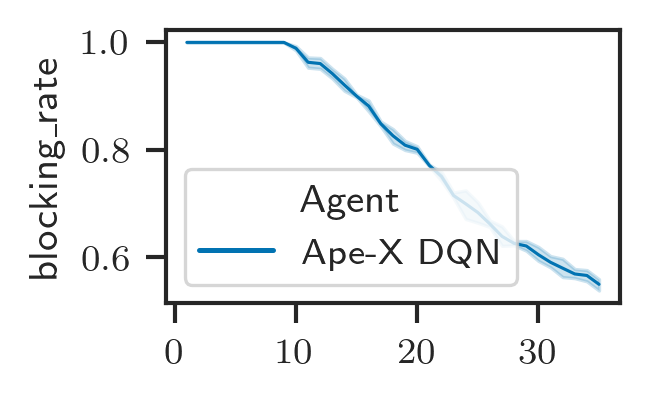

In [85]:
# metrics = ['score']
metrics = ['blocking_rate', 'score', 'episode_reward', 'mean_cluster_throughput', 'mean_demand_total_throughput']
for metric in metrics:
    lineplot(df=learner_agent_episode_stats_df, baseline_agent_df=baseline_agent_episode_stats_df, metric=metric)